# Logistic Regression
## Aspect sentiment anlysis (Vietnamese)
### Group 4
--- 
### Author

### This session is like previous assignmeent (but have bug fix on data loader)
---

## import requirement library

In [145]:
from underthesea import sent_tokenize
import pandas as pd
from pyvi import ViTokenizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
%matplotlib inline      

## Data-transformer class

this class allows us work with specific dataset in this case. You can read some data file in same repo to understand it's structure

---
### Descibe data
in each record 
* first line is number of record, it's start by # follow a number.
* second line is text.
* third line is aspect sentiment analyst has structure like {ENTITY#ATTRIBUTE, SENTIMENT} 

In [146]:
class Data_transformer:
    def __init__(self) -> None:
        self.__tokenizer = ViTokenizer
        pass
    def __removepunc(self, text):
        
        return re.sub(r'[^\w\s]','',text)
    def __tokenize(self, text):
        return self.__tokenizer.tokenize(text)
    def text_preprocessing(self, text):
        """_summary_
            Preprocessing function, this function include three step:
            * tokenize text (for Vietnamese),
            * remove punctuation,
            * lower_case text.
            * return result
        
        Args:
            text (string): raw test

        Returns:
            string: text's preprocessed
        """
        text_token = self.__tokenize(text)
        text_token = self.__removepunc(text_token)
        return text_token.lower()
    def read_text_only(self, filename):
        """_summary_
            This function will read only text in raw .txt file
       
        Args:
            filename (string): path to data file

        Returns:
            list: list of raw text
        """
        texts = []
        with open(filename, 'r', encoding='utf-8') as f:
            lines = filter(None, (line.rstrip() for line in f))
            for line in lines:
                line = line.strip()
                if line.startswith('#'):
                    try:
                        index = int(line[1:])
                        pass
                    except:
                        texts.append(line)
                elif line.startswith('{') and line.endswith('}'):
                    pass
                else:
                    texts.append(line)
        return texts
    def load_data(self, filename):
        """_summary_
            This function return data represent in 2d list.
            it has exactly 4 column incude: text, sentiment, entity and attribute. 
            *Remember each text will be seperated into many sentences.
        
        Args:
            filename (string): path to data

        Returns:
            list: 2d list for all record
        """
        data = []
        with open(filename, 'r', encoding='utf-8') as f:
            index = 0
            texts = []
            for line in f:
                line = line.strip()
                if line.startswith('#'):
                    try:
                        index = int(line[1:])
                    except:
                        texts = sent_tokenize(line)
                    pass
                elif line.startswith('{') and line.endswith('}'):
                    aspects = re.findall(r'{(.+?),\s*(.+?)}', line)
                    min_len = len(aspects) if len(aspects)<len(texts) else len(texts) 
                    for i in range(min_len):
                        aspect, sentiment = aspects[i]
                        text = texts[i]
                        s_attribute = aspect.split('#')
                        data_line = [self.text_preprocessing(text), sentiment, s_attribute[0], s_attribute[1]]
                        data.append(data_line) 
                else:
                    texts = sent_tokenize(line)
        return data
    def load_to_df(self, filename, columns = ['text', 'label', 'entity', 'attribute']):
        """_summary_
        
            This function return pandas dataframe.
            it has exactly 4 column incude: text, sentiment, entity and attribute. 
            *Remember each text will be seperated into many sentences.
        
        Args:
            filename (string): path to data
            columns (list): list of column's name.
        Returns:
            list: pandas dataframe
        """
        data = self.load_data(filename)
        df = pd.DataFrame(data=data, columns=columns)
        return df
    def text2feature(self, text):
        """_summary_
            This function will break a normal text into list of sentences and preprocess each sentences
        
        Args:
            text (string): raw text

        Returns:
            list: list of sentences's preprocessed
        """
        list_f = []
        list_text = sent_tokenize(text)
        for text in list_text:
            list_f.append(self.text_preprocessing(text))
        return list_f

---
### End same session

## Logistic Regression model
This class is multinomial Logistic regression model (aspect-sentiment_analyst approach) use bag of word as features 

**Note** that this class work for this data inclute 3 layer ENTITY, ATRIBUTE and SENTIMENT

In [147]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
class Aspect_logreg_model:
    def __init__(self) -> None:
        self.data_trans = Data_transformer()
        self.pineline = Pipeline([
            ('cv', CountVectorizer()),
            ('tf', TfidfTransformer()),

            ('nb', LogisticRegression())
        ])
        pass
    def reversed_normal_scale(self, lis):
        arr = 1 - lis/np.sum(lis)
        return arr/np.sum(arr)
    def fit3layer(self, df:pd.DataFrame, x_index = 0, y_indexes = [1,2,3]):
        """_summary_
            ***IMPORTANT***
            This is a main fit function to work for aspect sentiment analysis, it will fit for all 3-layer.
            Wanna predict, evaluate each aspect? Pls call .pipeline_<element>.<attribute> you want to work. 
            Note that you have to call this function before you want to use these attribute.
            <element> include [sen, entity, attribute]
        
        Args:
            df: pandas.DataFrame: a dataframe to fit for this model, you dont need to seperate into features and label, just pass dataframe, it auto do it for you.
            ***IMPORTANT***
            Dataframe must be a result of Data_transformer class
            x_index: int: index of text (must integer, no matter what index you use for dataframe, pass position of text series), we will create feature for you . 
            y_indexes: list<int>: List of classs index (must integer, no matter what index you use for dataframe, pass position of text series)
        """
        self.list_of_name = df.columns
        self.x_index = x_index
        self.y_index = y_indexes
        X = df[self.list_of_name[x_index]]
        self.models = []

        for label_index in y_indexes:
             self.models.append(
                  Pipeline([
                        ('cv', CountVectorizer()),
                        ('tf', TfidfTransformer()),
                        ('rbs', RobustScaler(with_centering=False)),
                        #('mas', MaxAbsScaler()),
                        #('sd', StandardScaler(with_mean=False)),
                        ('logreg', LogisticRegression(verbose=1, tol=0.1, C=1, solver='newton-cg'))
                ])
             )
        for k in range(len(y_indexes)):
             self.models[k].fit(X, df[self.list_of_name[y_indexes[k]]])
        pass 
    def fit_mono(self, X_, y_)->None:
        """_summary_
            Fit for specific class you want, if you want use this model simply call .pipeline.<attribute you want>
        
        Args:
            X_ (_type_): _description_
            y_ (_type_): _description_
        """
        X = X_
        y = y_ 
        self.pineline.fit(X, y)
        pass
    def evaluate(self, df)->None:
        """_summary_
        This will evalute 3 layer inclute sentiment, entity and attribute
        
        Args:
            dataframe: test dataframe
        """
        X = df[self.list_of_name[self.x_index]]
        for k in range(len(self.y_index)):
             y_pred = self.models[k].predict(X)
             y_true = df[self.list_of_name[self.y_index[k]]]
             print(classification_report(y_true=y_true, y_pred=y_pred, zero_division=1))
    def specific_class_report(self, X, y, model):
            y_pred = model.predict(X)
            print(classification_report(y, y_pred))
    def detail_predict(self, text):
        """_summary_
            This function will predict aspect sentiment for a text, include entity, attribute and sentimet. 
            Structure of predict will be like this {ENTITY#ATTRIBUTE, SENTIMENT}
        
        Args:
            text (string): text you want predict

        Returns:
            aspect-sentiment anlyst: list of sentiment-analys have structure like i describe above
        """
        aspect_l = []
        texts = self.data_trans.text2feature(text)
        for text in texts:
            entity = self.models[1].predict([text])
            attr = self.models[2].predict([text])
            sen = self.models[0].predict([text])
            aspect_l.append(f'{{{entity[0]}#{attr[0]}, {sen[0]}}}')
        return aspect_l

## Hotel dataset 
Work with hotel dataset

In [148]:
data_trans = Data_transformer()
data1 = data_trans.load_to_df('data_hotel_train.txt')
data2 = data_trans.load_to_df('data_hotel_test.txt')
df = pd.concat([data1,data2])
df.head(5)

,text,label,entity,attribute
0,rộng_rãi ks mới nhưng rất vắng,positive,HOTEL,DESIGN&FEATURES
1,các dịch_vụ chất_lượng chưa cao và thiếu,negative,HOTEL,GENERAL
2,địa_điểm thuận_tiện trong vòng bán_kính 15 km...,positive,LOCATION,GENERAL
3,phục_vụ view đẹp vị_trí,positive,SERVICE,GENERAL
4,thuận_tiện sạch_sẽ vui_vẻ hài_lòng,positive,HOTEL,COMFORT


### Data exploration
This part just give us a visualization for class distribution

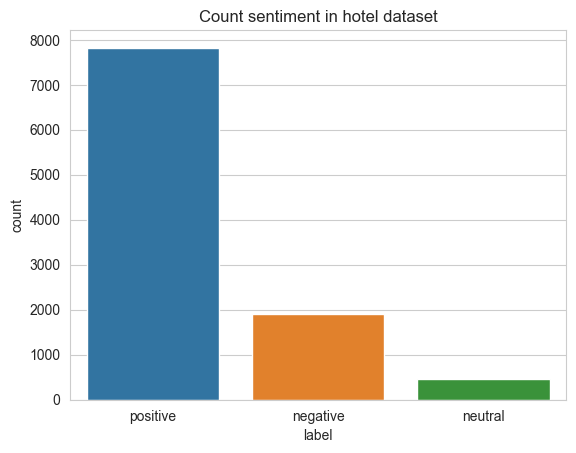

In [149]:
sns.countplot(df,x='label')
plt.title("Count sentiment in hotel dataset")
plt.show()

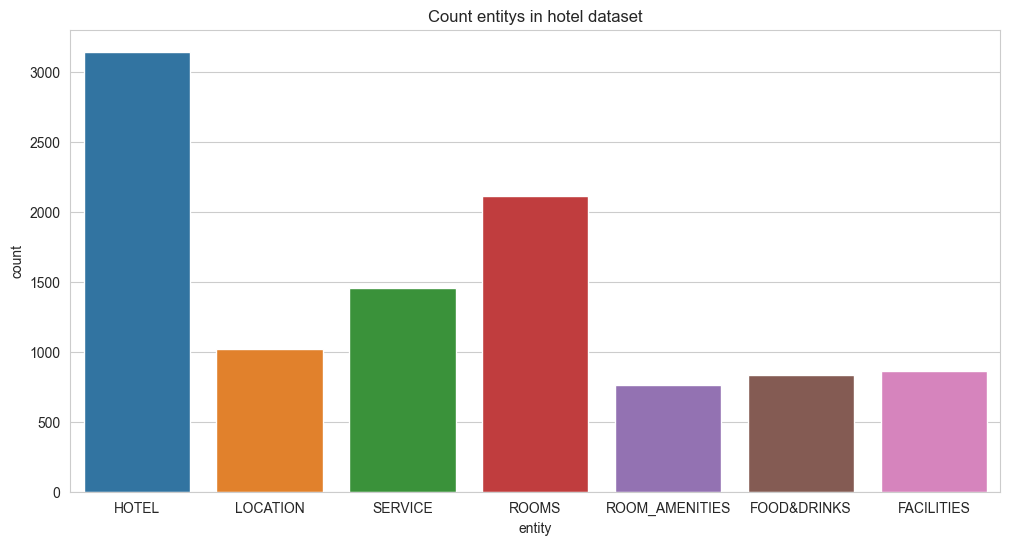

In [150]:
plt.figure(figsize=(12,6))
sns.countplot(df,x='entity')
plt.title("Count entitys in hotel dataset")
plt.show()

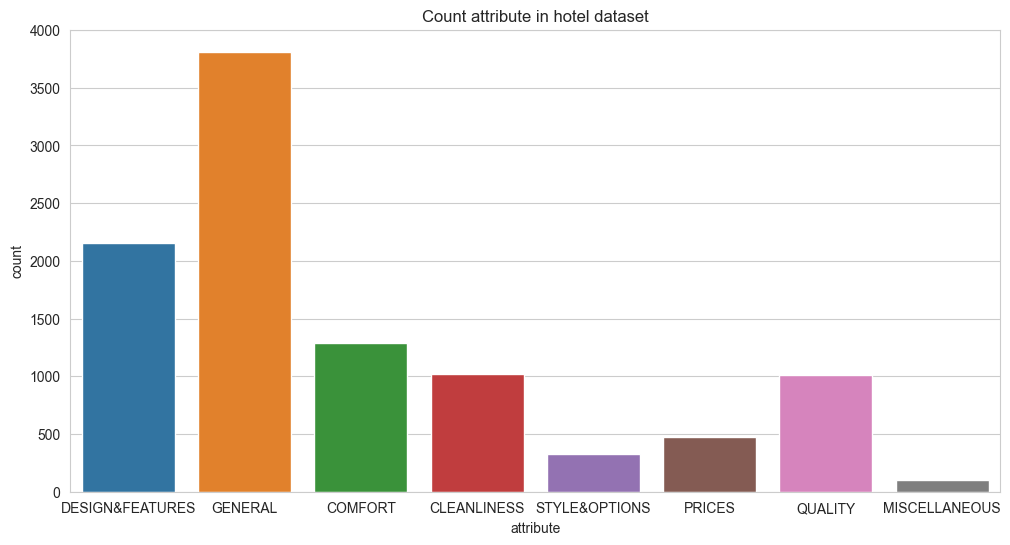

In [151]:
plt.figure(figsize=(12,6))
sns.countplot(df,x='attribute')
plt.title("Count attribute in hotel dataset")
plt.show()

We find that there are  unblanced label on all sentiment, attribute and entity

### Fit model

In [152]:
train_ratio = 0.8
from sklearn.utils import shuffle
df = shuffle(df)
n_records,_ = df.shape
df_train = df.iloc[:int(train_ratio*n_records)]
df_test = df.iloc[int(train_ratio*n_records):]

In [153]:
model = Aspect_logreg_model()
model.fit3layer(df_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


Try to aspect sentiment analyst in specific text

In [154]:
model.detail_predict("Giá cả khá mềm, hợp với túi tiền. Phòng sạch, gọn gàng. Tôi khá hài lòng với Khách sạn này trong kỳ nghỉ vừa rồi. Rất cảm ơn Mytour đã hỗ trợ.")

['{HOTEL#DESIGN&FEATURES, positive}',
 '{ROOMS#CLEANLINESS, positive}',
 '{HOTEL#COMFORT, positive}',
 '{SERVICE#GENERAL, positive}']

Seem it works well with positive comment

In [155]:
model.detail_predict("Nhân viên lịch sự, phục vụ chu đáo. Khách sạn ở sạch sẽ. Bãi biển không được sạch sẽ lắm, có nhiều rác, nước đục")

['{SERVICE#GENERAL, positive}',
 '{HOTEL#CLEANLINESS, positive}',
 '{ROOMS#CLEANLINESS, negative}']

It still work with a review has negative sentiment.

### Evalute 

on train dataset

In [156]:
model.evaluate(df_train)

              precision    recall  f1-score   support

    negative       0.79      0.51      0.62      1519
     neutral       0.73      0.04      0.08       374
    positive       0.85      0.98      0.91      6259

    accuracy                           0.85      8152
   macro avg       0.79      0.51      0.54      8152
weighted avg       0.84      0.85      0.82      8152

                precision    recall  f1-score   support

    FACILITIES       0.62      0.32      0.42       697
   FOOD&DRINKS       0.57      0.33      0.41       667
         HOTEL       0.54      0.84      0.65      2511
      LOCATION       0.67      0.50      0.57       799
         ROOMS       0.55      0.61      0.58      1695
ROOM_AMENITIES       0.68      0.27      0.39       614
       SERVICE       0.55      0.37      0.44      1169

      accuracy                           0.56      8152
     macro avg       0.60      0.46      0.50      8152
  weighted avg       0.58      0.56      0.54      8152



In sentiment it has F1-score accuracy pretty good, but just in positive, and very bad on neutral, because our data set very unbalanced and there are many class (7 for entity, 8 for attribute),
With entity and attribute all have bad performence, maybe our data unbalanced and there are many class, but dataset dont large enough. the result will be easily skewed towards the dominant class 

In [157]:
model.evaluate(df_test)

              precision    recall  f1-score   support

    negative       0.59      0.36      0.44       391
     neutral       0.75      0.04      0.07        83
    positive       0.83      0.95      0.88      1565

    accuracy                           0.80      2039
   macro avg       0.72      0.45      0.47      2039
weighted avg       0.78      0.80      0.77      2039

                precision    recall  f1-score   support

    FACILITIES       0.37      0.15      0.22       168
   FOOD&DRINKS       0.33      0.20      0.25       164
         HOTEL       0.46      0.72      0.56       636
      LOCATION       0.61      0.42      0.50       219
         ROOMS       0.41      0.43      0.42       418
ROOM_AMENITIES       0.35      0.13      0.19       149
       SERVICE       0.33      0.25      0.28       285

      accuracy                           0.43      2039
     macro avg       0.41      0.33      0.34      2039
  weighted avg       0.42      0.43      0.40      2039



In test dataset it's little lower perfomance in sentiment and littel bad performance with entity and attribute.

I have used standardScaler before fit model, it have perfect F1 score but just in train, and very bad on test set, mean that approach meet with overfitting, so this model more generalize than previous model.

Test with 10 review from test data

In [158]:
textlist = data_trans.read_text_only('data_hotel_test.txt')
for i in range(10, 20):
    print(f'#{i+1}')
    text = textlist[i]
    print(text)
    print(str(model.detail_predict(text)))
    

#11
khách sạn nhỏ nhưng rất đẹp và sang trọng , nhân viên vui vẻ nhiệt tình , giá cả hợp lý cho một khách sạn gần biển .
['{HOTEL#GENERAL, positive}']
#12
Không giống như quảng cáo và đánh giá trên booking. Đặt phòng suite nhưng vì hết nên cho lên phòng cao nhất nằm phía sau, k có cửa kính ban công như đã Book trước đó. Chúng tôi được yêu cầu không động vào giường bên cạnh vì giá đặt là phòng 1 giường. Ok không sao nhưng phòng quá nhiều muỗi. Mình mang theo bé 3 tháng phải trả phòng trong đêm vì muỗi quá nhiều không thể ngủ được. Toilet bẩn, bàn trà bẩn, lau không sạch, còn rất nhiều vết trà và cà phê cũ. Nền gạch rít do không lau. Không có ly uống nước, mặc dù đi thang máy xuống nhiều lần nhưng ks bảo không có ly. Trong khi lại để trà và cà phê trên bàn. Theo đánh giá khen trên booking đa phần nói nội thất mới mình không hề thấy mới. Rất cũ kĩ. Phòng thì rộng và đẹp, giá cũng rẻ nhưng quá tệ phong cách phục vụ. Từ khi vào ở đến lúc check out lễ tân đều đi ngủ trong phòng không ra tiếp

## Restaurant
Use logistic regression model for restaurant dataset

In [159]:
df_res1 = data_trans.load_to_df('data_Restaurant_train.txt')
df_res2 = data_trans.load_to_df('data_Restaurant_test.txt')
df_res = pd.concat([df_res1,df_res2])

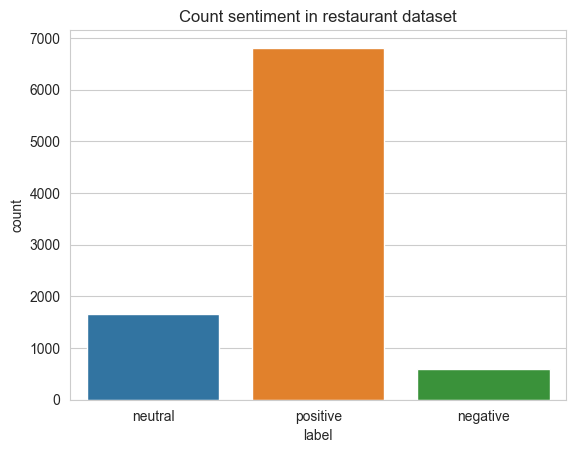

In [160]:
sns.countplot(df_res,x='label')
plt.title("Count sentiment in restaurant dataset")
plt.show()

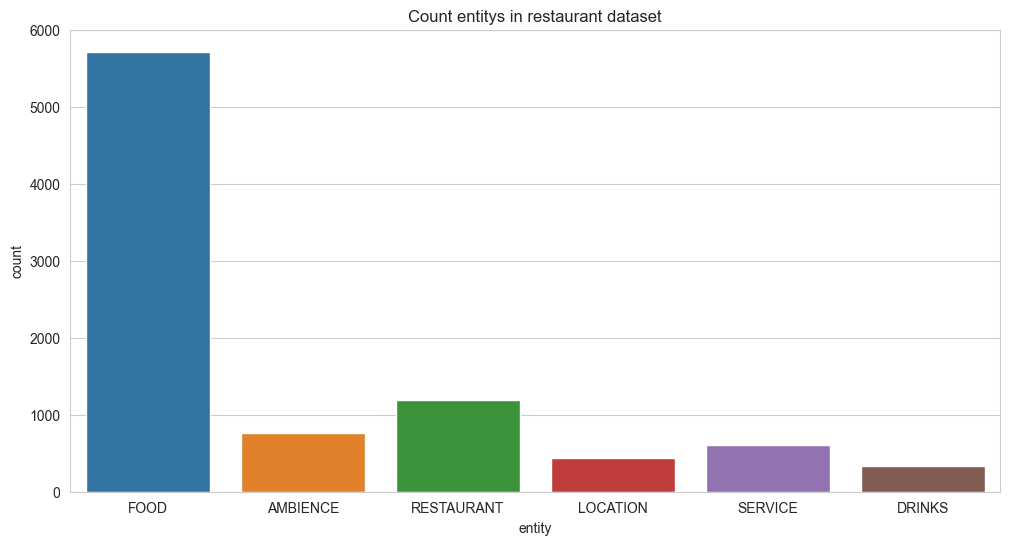

In [161]:
plt.figure(figsize=(12,6))
sns.countplot(df_res,x='entity')
plt.title("Count entitys in restaurant dataset")
plt.show()

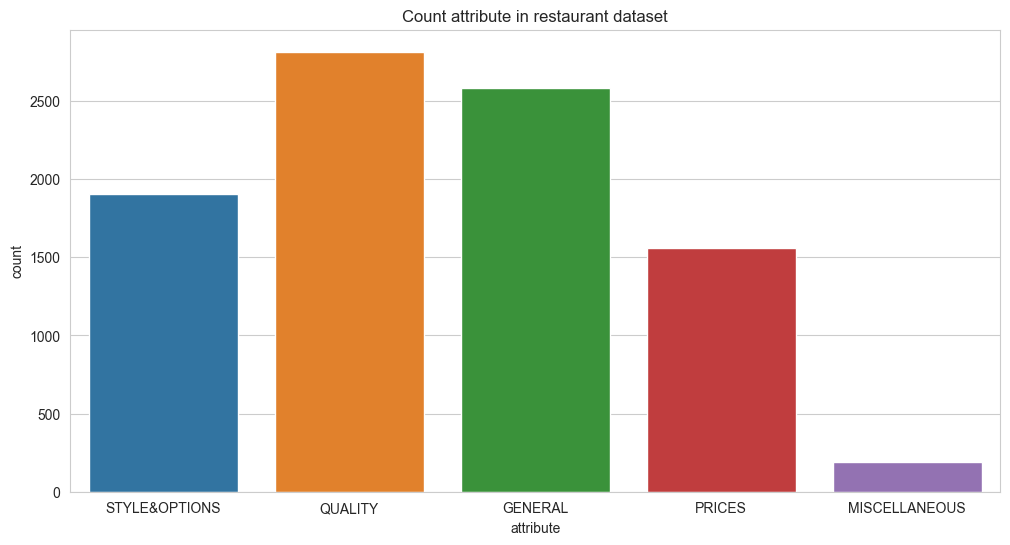

In [162]:
plt.figure(figsize=(12,6))
sns.countplot(df_res,x='attribute')
plt.title("Count attribute in restaurant dataset")
plt.show()

In [163]:
df_res = shuffle(df_res)
n_records,_ = df_res.shape
df_res_train = df_res.iloc[:int(train_ratio*n_records)]
df_res_test = df_res.iloc[int(train_ratio*n_records):]

In [164]:
model_res = Aspect_logreg_model()
model_res.fit3layer(df_res_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Test with specific text

In [165]:
print(model_res.detail_predict('chổ này gần nhà mình nên ghé thử, quán thoáng mát, nhân viên phục vụ chu đáo, món ăn vừa túi sinh viên! có mấy món lạ nữa kết nhất là cái cánh vịt đó'))

['{AMBIENCE#GENERAL, positive}', '{FOOD#GENERAL, positive}']


In [166]:
model_res.evaluate(df_res_train)

              precision    recall  f1-score   support

    negative       0.93      0.06      0.11       466
     neutral       0.78      0.19      0.31      1321
    positive       0.79      0.99      0.88      5455

    accuracy                           0.79      7242
   macro avg       0.83      0.41      0.43      7242
weighted avg       0.80      0.79      0.72      7242

              precision    recall  f1-score   support

    AMBIENCE       0.67      0.19      0.29       607
      DRINKS       0.65      0.11      0.19       272
        FOOD       0.68      0.98      0.81      4562
    LOCATION       0.75      0.26      0.39       358
  RESTAURANT       0.73      0.21      0.32       952
     SERVICE       0.62      0.09      0.16       491

    accuracy                           0.68      7242
   macro avg       0.68      0.31      0.36      7242
weighted avg       0.69      0.68      0.61      7242

               precision    recall  f1-score   support

      GENERAL       

In [167]:
model_res.evaluate(df_res_test)

              precision    recall  f1-score   support

    negative       0.33      0.02      0.05       123
     neutral       0.38      0.08      0.13       333
    positive       0.76      0.98      0.86      1355

    accuracy                           0.75      1811
   macro avg       0.49      0.36      0.34      1811
weighted avg       0.66      0.75      0.67      1811

              precision    recall  f1-score   support

    AMBIENCE       0.43      0.10      0.16       154
      DRINKS       0.50      0.03      0.06        60
        FOOD       0.67      0.96      0.79      1157
    LOCATION       0.52      0.18      0.27        84
  RESTAURANT       0.29      0.09      0.13       235
     SERVICE       0.31      0.03      0.06       121

    accuracy                           0.64      1811
   macro avg       0.45      0.23      0.24      1811
weighted avg       0.56      0.64      0.55      1811

               precision    recall  f1-score   support

      GENERAL       

We meet the same issue with hotel dataset.
I think solution for this case ís make dataset more balanced, but don't scale down our dataset, we need more time to work with dataset.

I try to use standardscale for feature, it have a dreamy accuracy score on train dataset, but very bad on test dataset (overfitting). So, skip that

Test with 10 review from test data

In [168]:
textlist = data_trans.read_text_only('data_Restaurant_test.txt')
for i in range(50,60):
    print(f'#{i+1}')
    text = textlist[i]
    print(text)
    print(str(model_res.detail_predict(text)))

#51
Thèm bánh canh ghê mà ngày nào cũng có tô bánh canh hẹ này ăn là dzui đời gòi. Tô bánh canh hẹ 40k mà vô vàn chả cá (mặc dù hơi khô), trứng cút và 1 đống hẹ. Nước lèo thơm mùi chả cá và thanh, ko tanh. Dĩa bánh bèo 32k được 12 cái nhỏ mà bột dày quá, lại khô nữa, ko đáng tiền. Có điều thích mấy miếng bánh mì chiên trên mặt, ăn giòn rụm. Nước mắm pha ngon, vừa miệng. Dĩa bánh bột lọc 6 cái 36k ăn được hơn bánh bèo nhưng nếu bột mềm hơn tí nữa thì ngon hơn. Thích nhất là ở đây dùng mỡ hẹ, ko phải mỡ hành nên món nào cũng thơm phức mùi hẹ. Nói chung là quản bá đặc sản xứ Nẫu thành công nhóe 👍👄
['{FOOD#STYLE&OPTIONS, positive}', '{FOOD#STYLE&OPTIONS, neutral}', '{FOOD#QUALITY, positive}', '{FOOD#GENERAL, positive}', '{FOOD#GENERAL, positive}', '{FOOD#QUALITY, positive}', '{FOOD#QUALITY, positive}', '{FOOD#STYLE&OPTIONS, positive}', '{FOOD#QUALITY, positive}']
#52
Chú bán món bánh bò lá dứa cũng khá lâu rồi đó, bán cố định thứ 2 từ 9h-12h đêm tại Ngã 4 Trần hưng đạo giao với Phùng hưng 

# Conclusion
Our special logistic regression model solved aspect base sentiment analysis problem, althought performance not good, but maybe there is a way to improve it in future.

---

# Thank for you reading.